# Example T30 v6: HSS Brace Analysis
The photo shows the end details of a typical brace in a 4-storey steel structure.  This was photographed in Ottawa, in September, 2015.

This notebook shows the computations necessary to compute the factored tension resistance, $T_r$, for a similar brace.  **Note**, all of the dimensions and properties were invented by the author of this notebook; no attempt has been made to have an accurate model of the real structure.

In [1]:
from Designer import Part, DesignNotes, SST
import math
sind = lambda deg: math.sin(math.radians(deg))  # return sin of angle expressed in degrees
cosd = lambda deg: math.cos(math.radians(deg))  # return cos of angle expressed in degrees

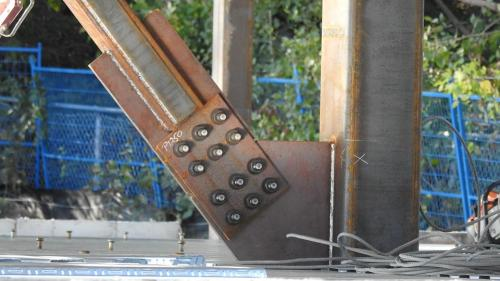

In [2]:
%figure "brace.jpg"

![Overall Sketch](brace-sketch.svg)

**Setup the units system**

In [3]:
import pint                  # setup to use the module for computing with units
ureg = pint.UnitRegistry()
mm = ureg['mm']              # define symbols for the units used below
inch = ureg['inch']
kN = ureg['kN']
MPa = ureg['MPa']
ureg.default_format = '~P'

The various $\phi$ values used below:

In [4]:
phiw = 0.67    # S16-14 13.1
phiu = 0.75
phib = 0.80
phibr = 0.80
phi = 0.90

In [5]:
notes = DesignNotes('Tr',title='Typical HSS Cross Brace',units=kN,trace=True)

# useful abbreviations:
REQUIRE = notes.require       # a requirement
CHECK = notes.check           # a check
RECORD = notes.record         # record calculation details
SETVARS = notes.setvars       # extract attribute values as variables

## Design Parameters
Most of the design parameters from the above figure are defined here.  A few are augmented or defined below where there are more detailed figures available.

In [6]:
class Bolts(Part):
    'Bolts'   # bolt group is the same on the tongue plate and on the gusset plate.
    grade = 'ASTM A325'
    size = '3/4"'
    Fu = 825*MPa
    d = (3/4*inch).to(mm)
    hole_type = 'punched'
    hd = 22*mm            # hole diameter
    ha = hd + 2*mm        # hole allowance
    threads_intercepted = True
    nlines = 2            # a line is perpendicular to load
    nperline = 3          # number of bolts in each line
    g = 75*mm             # gauge (perpendicular to load)
    s = 75*mm             # spacing (parallel to load)

class Welds(Part):
    'Welds'
    grade = 'E49xx'
    Xu = 490*MPa
    matching = True

class Plates(Part):
    'Plates'
    grade = 'CSA G40.21 350W'
    Fy = 350*MPa
    Fu = 450*MPa

class HSS(Part):
    'HSS Column'
    grade = 'CSA G40.21 350W'
    Fy = 350*MPa
    Fu = 450*MPa
    size = 'HS127x127x13'
    D,T,A = SST.section(size,'D,T,A')
    D = D*mm
    T = T*mm
    A = A*mm*mm    

class CoverPlate(Plates):
    'Cover Plate'
    T = 10*mm
    W = 60*mm
    Lw = 90*mm      # length of weld from net section to end of HSS
    D = 6*mm        # size of weld from on HSS.
   
class TonguePlate(Plates):
    'Tongue Plate'
    T = 20*mm
    W = 280*mm
    L = 260*mm
    e = 40*mm
    D = 8*mm       # weld size
    c = 45*mm      # dist end of weld to 1st bolt line  
    Lw = L - (c + (Bolts.nlines-1)*Bolts.s + e)
    Dh = SST.section(HSS.size,'D')*mm

class GussetPlate(TonguePlate['T,W'],Plates): 
    'Gusset Plate'
    W2 = 110*mm
    e = 40*mm    # end distance
    D = 8*mm     # plate to column weld size
    theta = 45. 

## Bolting and Welding Details

TBD: Here we should check all spacings, edge distances, etc.

## Gusset Plate
![Gusset Plate Details](gusset-details.svg)

### Gusset to HSS Weld

In [7]:
with SETVARS(GussetPlate['W,W2,theta,D'],Welds['Xu'],
             label='Gusset to HSS Weld',result_var='Vr',locals='L,L1,Mw,Aw'):
    L1 = W2+W*cosd(theta)
    L = (L1/sind(theta))*cosd(theta) + W*sind(theta)

    Mw = 1.0                  
    Aw = 2*L*.707*D
    Vr = 0.67*phiw*Aw*Xu*(1+sind(theta)**1.5)*Mw     # S16-14: 13.13.2.2

    Aw = 5724mm²
    D = 8mm
    L = 506.0mm
    L1 = 308.0mm
    Mw = 1.0
    theta = 45.0
    Tr = 2008kN
    Vr = 2008000MPa·mm²
    W = 280mm
    W2 = 110mm
    Xu = 490MPa

    Gusset to HSS Weld: Tr = 2008 kN

### Gusset Block Shear
Because the gusset must be the same thickness as the tongue, and as the edges align so they are the
same width (mostly), the block shear strengths determined here should be the same.  So this section is not
really necessary.  The tongue does have one more pattern (Pattern 3)) that is judged not applicable
here because of the increased width of the gusset.
#### Block Shear Case 1)

In [8]:
with SETVARS(Bolts['nlines,nperline,g,s,ha'],GussetPlate['W,e,T,Fy,Fu'],
             label='Gusset Block Shear Case 1)',result_var='Vr',local='An,Agv,Ut'):
    An = T*((nperline-1)*g - (nperline-1)*ha)
    Agv = 2*T*((nlines-1)*s + e)
    Ut = 1.0
    Vr = phiu*(Ut*An*Fu + 0.6*Agv*(Fy+Fu)/2.)     # S16-14: 13.2 a) ii) & 13.11

    Agv = 4600mm²
    An = 2040mm²
    e = 40mm
    Fu = 450MPa
    Fy = 350MPa
    g = 75mm
    ha = 24mm
    nlines = 2
    nperline = 3
    s = 75mm
    T = 20mm
    Tr = 1516kN
    Ut = 1.0
    Vr = 1516000MPa·mm²
    W = 280mm

    Gusset Block Shear Case 1): Tr = 1516 kN

#### Block Shear Case 2)

In [9]:
with SETVARS(Bolts['nlines,nperline,g,s,ha'],GussetPlate['W,e,T,Fy,Fu'],locals='edge,Ut,An,Agv,Vr',
             label='Gusset Block Shear Case 2)'):
    edge = (W - (nperline-1)*g)/2.
    An = (((nperline-1)*g+edge)-(nperline-0.5)*ha)*T
    Agv = T*((nlines-1)*s + e)
    Ut = 0.8
    Tr = Vr = phiu*(Ut*An*Fu + 0.6*Agv*(Fy+Fu)/2.)    # S16-14: 13.2 a) ii) & 13.11

    Agv = 2300mm²
    An = 3100mm²
    e = 40mm
    edge = 65.0mm
    Fu = 450MPa
    Fy = 350MPa
    g = 75mm
    ha = 24mm
    nlines = 2
    nperline = 3
    s = 75mm
    T = 20mm
    Tr = 1251kN
    Ut = 0.8
    Vr = 1251000MPa·mm²
    W = 280mm

    Gusset Block Shear Case 2): Tr = 1251 kN

#### Tearout

In [10]:
with SETVARS(Bolts['nlines,nperline,s'],GussetPlate['e,T,Fy,Fu'],locals='Agv,Vr',
             label='Gusset tearout'):    
    Agv = T*((nlines-1)*s + e) * nperline * 2
    Tr = Vr = phiu * 0.6*Agv*(Fy+Fu)/2.               # S16-14: 13.2 a) ii) & 13.11

    Agv = 13800mm²
    e = 40mm
    Fu = 450MPa
    Fy = 350MPa
    nlines = 2
    nperline = 3
    s = 75mm
    T = 20mm
    Tr = 2484kN
    Vr = 2484000MPa·mm²

    Gusset tearout: Tr = 2484 kN

## Lap Plates (2)
### Lap Plate Details
Consider the thickness of both plates together when computing the resistance.
As the plate is symmetric, we only have to investigate one end.

![Lap Plate Details](lap-plate-details.svg)

In [11]:
class LapPlates(Plates):
    'Lap Plates'
    W = 230*mm
    L = 315*mm
    T = 10*mm*2.      # thickness, include 2 plates
    e = 40*mm         # could be different than gusset

### Lap Plates: Gross Section Yield

In [12]:
with SETVARS(LapPlates['W,T,Fy'],locals='Ag',label='Lap Plates, Gross Yield'):
    Ag = W*T
    Tr = phi*Ag*Fy          # S16-14: 13.2 a) i)

    Ag = 4600mm²
    Fy = 350MPa
    T = 20.0mm
    Tr = 1449kN
    W = 230mm

    Lap Plates, Gross Yield: Tr = 1449 kN

### Lap Plates: Net Section Fracture

In [13]:
with SETVARS(LapPlates['W,T,Fu'],Bolts['nperline,ha'],locals='wn,Ane',label='Lap Plates, Net Fracture'):
    wn = W - nperline*ha
    Ane = An = wn*T
    Tr = phiu*Ane*Fu          # S16-14: 13.2 a) iii)

    Ane = 3160mm²
    Fu = 450MPa
    ha = 24mm
    nperline = 3
    T = 20.0mm
    Tr = 1066kN
    W = 230mm
    wn = 158mm

    Lap Plates, Net Fracture: Tr = 1066 kN

### Lap Plates: Block Shear
#### Block Shear Case 1)

In [14]:
with SETVARS(LapPlates['T,e,W,Fy,Fu'],Bolts['ha,nperline,nlines,s,g'],locals='An,Agv,Ut,Vr',
             label='Lap Plates, Block Shear Case 1)'):
    An = ((nperline-1)*g - (nperline-1)*ha)*T
    Agv = (e + (nlines-1)*s)*T*2
    Ut = 1.0
    Tr = Vr = phiu*(Ut*An*Fu + 0.6*Agv*(Fy+Fu)/2.)        # S16-14: 13.2 a) ii) & 13.11

    Agv = 4600mm²
    An = 2040mm²
    e = 40mm
    Fu = 450MPa
    Fy = 350MPa
    g = 75mm
    ha = 24mm
    nlines = 2
    nperline = 3
    s = 75mm
    T = 20.0mm
    Tr = 1516kN
    Ut = 1.0
    Vr = 1516000MPa·mm²
    W = 230mm

    Lap Plates, Block Shear Case 1): Tr = 1516 kN

#### Case 2)

In [15]:
with SETVARS(LapPlates['T,e,W,Fy,Fu'],Bolts['ha,nperline,nlines,s,g'],locals='edge,An,Agv,Ut,Vr',
             label='Lap Plates, Block Shear Case 2)'):
    edge = (W - (nperline-1)*g)/2.0
    An = (W - (edge-ha/2) - nperline*ha)*T
    Agv = (e + (nlines-1)*s)*T
    Ut = 0.8
    Tr = Vr = phiu*(Ut*An*Fu + 0.6*Agv*(Fy+Fu)/2.)       # S16-14: 13.2 a) ii) & 13.11

    Agv = 2300mm²
    An = 2600mm²
    e = 40mm
    edge = 40.0mm
    Fu = 450MPa
    Fy = 350MPa
    g = 75mm
    ha = 24mm
    nlines = 2
    nperline = 3
    s = 75mm
    T = 20.0mm
    Tr = 1116kN
    Ut = 0.8
    Vr = 1116000MPa·mm²
    W = 230mm

    Lap Plates, Block Shear Case 2): Tr = 1116 kN

#### Case 3)

In [16]:
with SETVARS(LapPlates['T,e,W,Fy,Fu'],Bolts['ha,nperline,nlines,s,g'],locals='An,Agv,Ut,Vr',
             label='Lap Plates, Block Shear Case 3)'):
    An = (W - nperline*ha - (g-ha))*T
    Agv = (e + (nlines-1)*s)*T * 2.
    Ut = 0.6
    Tr = Vr = phiu*(Ut*An*Fu + 0.6*Agv*(Fy+Fu)/2.)        # S16-14: 13.2 a) ii) & 13.11

    Agv = 4600mm²
    An = 2140mm²
    e = 40mm
    Fu = 450MPa
    Fy = 350MPa
    g = 75mm
    ha = 24mm
    nlines = 2
    nperline = 3
    s = 75mm
    T = 20.0mm
    Tr = 1261kN
    Ut = 0.6
    Vr = 1261000MPa·mm²
    W = 230mm

    Lap Plates, Block Shear Case 3): Tr = 1261 kN

#### Tearout

In [17]:
with SETVARS(LapPlates['T,e,W,Fy,Fu'],Bolts['ha,nperline,nlines,s,g'],locals='Agv,Vr,An,Ut',
             label='Lap Plates, tearout'):
    An = 0*mm*mm
    Agv = (e + (nlines-1)*s)*T*2*nperline
    Ut = 1
    Tr = Vr = phiu*(Ut*An*Fu + 0.6*Agv*(Fy+Fu)/2.)        # S16-14: 13.2 a) ii) & 13.11

    Agv = 13800mm²
    An = 0mm²
    e = 40mm
    Fu = 450MPa
    Fy = 350MPa
    g = 75mm
    ha = 24mm
    nlines = 2
    nperline = 3
    s = 75mm
    T = 20.0mm
    Tr = 2484kN
    Ut = 1
    Vr = 2484000MPa·mm²
    W = 230mm

    Lap Plates, tearout: Tr = 2484 kN

## Tongue Plate
### Tongue Plate Details
![Tongue Plate Details](tongue-plate-details.svg)

In [18]:
class TonguePlate(TonguePlate):
    D = 8*mm       # weld size
    c = 45*mm      # dist end of weld to 1st bolt line  
    Lw = TonguePlate.L - (c + (Bolts.nlines-1)*Bolts.s + TonguePlate.e)
    Dh = SST.section(HSS.size,'D')*mm

### Tongue Plate: Bolted End
#### Gross Section Yield

In [19]:
with SETVARS(TonguePlate['W,T,Fy'],locals='Ag',
             label='Tongue Plate, Gross Yield'):
    Ag = W*T
    Tr = phi*Ag*Fy                # S16-14: 13.2 a) i)

    Ag = 5600mm²
    Fy = 350MPa
    T = 20mm
    Tr = 1764kN
    W = 280mm

    Tongue Plate, Gross Yield: Tr = 1764 kN

#### Net Section Fracture

In [20]:
with SETVARS(TonguePlate['W,T,Fu'],Bolts['ha,nperline'],locals='wn,Ane',
             label='Tongue Plate, Bolted End, Net Section Fracture'):
    wn = W - nperline*ha
    Ane = An = wn*T
    Tr = phiu*Ane*Fu              # S16-14: 13.2 a) iii)

    Ane = 4160mm²
    Fu = 450MPa
    ha = 24mm
    nperline = 3
    T = 20mm
    Tr = 1404kN
    W = 280mm
    wn = 208mm

    Tongue Plate, Bolted End, Net Section Fracture: Tr = 1404 kN

#### Block Shear, Case 1)

In [21]:
with SETVARS(TonguePlate['T,e,W,Fy,Fu'],Bolts['ha,nperline,nlines,s,g'],locals='An,Agv,Ut,Vr',
             label='Tongue Plate, Block Shear Case 1)'):
    An = ((nperline-1)*g - (nperline-1)*ha)*T
    Agv = (e + (nlines-1)*s)*T*2
    Ut = 1.0
    Tr = Vr = phiu*(Ut*An*Fu + 0.6*Agv*(Fy+Fu)/2.)     # S16-14: 13.2 a) ii) & 13.11

    Agv = 4600mm²
    An = 2040mm²
    e = 40mm
    Fu = 450MPa
    Fy = 350MPa
    g = 75mm
    ha = 24mm
    nlines = 2
    nperline = 3
    s = 75mm
    T = 20mm
    Tr = 1516kN
    Ut = 1.0
    Vr = 1516000MPa·mm²
    W = 280mm

    Tongue Plate, Block Shear Case 1): Tr = 1516 kN

#### Block Shear, Case 2)

In [22]:
with SETVARS(TonguePlate['T,e,W,Fy,Fu'],Bolts['ha,nperline,nlines,s,g'],locals='edge,An,Agv,Ut,Vr',
             label='Tongue Plate, Block Shear Case 2)'):
    edge = (W - (nperline-1)*g)/2.0
    An = (W - (edge-ha/2.) - nperline*ha)*T
    Agv = (e + (nlines-1)*s)*T
    Ut = 0.8
    Tr = Vr = phiu*(Ut*An*Fu + 0.6*Agv*(Fy+Fu)/2.)      # S16-14: 13.2 a) ii) & 13.1

    Agv = 2300mm²
    An = 3100mm²
    e = 40mm
    edge = 65.0mm
    Fu = 450MPa
    Fy = 350MPa
    g = 75mm
    ha = 24mm
    nlines = 2
    nperline = 3
    s = 75mm
    T = 20mm
    Tr = 1251kN
    Ut = 0.8
    Vr = 1251000MPa·mm²
    W = 280mm

    Tongue Plate, Block Shear Case 2): Tr = 1251 kN

#### Block Shear, Case 3)

In [23]:
with SETVARS(TonguePlate['T,e,W,Fy,Fu'],Bolts['ha,nperline,nlines,s,g'],locals='An,Agv,Ut,Vr',
             label='Tongue Plate, Block Shear Case 3)'):
    An = (W - nperline*ha - (g-ha))*T
    Agv = (e + (nlines-1)*s)*T * 2.
    Ut = 0.6
    Tr = Vr = phiu*(Ut*An*Fu + 0.6*Agv*(Fy+Fu)/2.)       # S16-14: 13.2 a) ii) & 13.11

    Agv = 4600mm²
    An = 3140mm²
    e = 40mm
    Fu = 450MPa
    Fy = 350MPa
    g = 75mm
    ha = 24mm
    nlines = 2
    nperline = 3
    s = 75mm
    T = 20mm
    Tr = 1464kN
    Ut = 0.6
    Vr = 1464000MPa·mm²
    W = 280mm

    Tongue Plate, Block Shear Case 3): Tr = 1464 kN

#### Block Shear, Tearout

In [24]:
with SETVARS(TonguePlate['T,e,W,Fy,Fu'],Bolts['ha,nperline,nlines,s,g'],locals='Agv,Vr,An,Ut',
             label='Tongue Plate tearout'):
    An = 0*mm*mm
    Agv = (e + (nlines-1)*s)*T*2*nperline
    Ut = 1
    Tr = Vr = phiu*(Ut*An*Fu + 0.6*Agv*(Fy+Fu)/2.)       # S16-14: 13.2 a) ii) & 13.11

    Agv = 13800mm²
    An = 0mm²
    e = 40mm
    Fu = 450MPa
    Fy = 350MPa
    g = 75mm
    ha = 24mm
    nlines = 2
    nperline = 3
    s = 75mm
    T = 20mm
    Tr = 2484kN
    Ut = 1
    Vr = 2484000MPa·mm²
    W = 280mm

    Tongue Plate tearout: Tr = 2484 kN

### Tongue Plate: Welded End
#### Shear Lag - Effective Net Area

In [25]:
with SETVARS(TonguePlate['W,w2=Dh,L=Lw,T,Fu'],locals='w3,An2,An3,Ane',
             label='Tongue Plate, Welded End, Net Section Fracture'):
    if L >= 2*w2:             # S16-14: 12.3.3.3 b)
        An2 = 1.00*w2*T
    elif L >= w2:
        An2 = 0.5*w2*T + 0.25*L*T
    else:
        An2 = 0.75*L*T

    w3 = (W-w2)/2.            # S16-14: 12.3.3.3 c)
    xbar = w3/2.
    if L >= w3:
        An3 = (1.-xbar/L)*w3*T
    else:
        An3 = 0.50*L*T
    Ane = An2 + An3 + An3     # S16-14: 12.3.3.3 
    Tr = phiu*Ane*Fu

    An2 = 1500mm²
    An3 = 944.8mm²
    Ane = 3390mm²
    Fu = 450MPa
    L = 100mm
    T = 20mm
    Tr = 1144kN
    W = 280mm
    w2 = 127.0mm
    w3 = 76.5mm

    Tongue Plate, Welded End, Net Section Fracture: Tr = 1144 kN

## Fasteners
### Bolts
#### Shear

In [26]:
with SETVARS(Bolts['d,Fu,threads_intercepted,s,nlines,nperline'],locals='n,m,Ab,Vr',
             label='Bolts in Shear'):
    n = nlines*nperline             # no. of bolts
    m = 2                           # no. of faying surfaces
    Ab = 3.14159*d*d/4.
    Vr = 0.6*phib*n*m*Ab*Fu         # S16-14: 13.12.1.2 c)
    L = (nlines-1)*s
    if L >= 760*mm:
        Vr = (0.5/0.6)*Vr
    if threads_intercepted:
        Vr = 0.7*Vr
    Tr = Vr

    Ab = 285.0mm²
    d = 19.05mm
    Fu = 825MPa
    m = 2
    n = 6
    nlines = 2
    nperline = 3
    s = 75mm
    threads_intercepted = True
    Tr = 948.1kN
    Vr = 948100MPa·mm²

    Bolts in Shear: Tr = 948.1 kN

#### Bearing

In [27]:
with SETVARS(Bolts['d,nlines,nperline'],TonguePlate['Fu'],locals='n,t,Br',
             label='Bolts in Bearing'):
    n = nlines*nperline
    t = min(GussetPlate.T,TonguePlate.T,2*LapPlates.T)
    Tr = Br = 3*phibr*n*t*d*Fu          # S16-14: 13.12.1.2 a)

    Br = 2469000MPa·mm²
    d = 19.05mm
    Fu = 450MPa
    n = 6
    nlines = 2
    nperline = 3
    t = 20mm
    Tr = 2469kN

    Bolts in Bearing: Tr = 2469 kN

### Welds - HSS to Tongue Plate

In [28]:
with SETVARS(TonguePlate['L=Lw,D'],Welds['Xu,matching'],locals='Aw,Vr',
             label='Fillet Weld (HSS to Plate)'):
    if not matching:
        raise Exception('Non matching electrodes')
    Aw = 4.*L*D*0.707
    Tr = Vr = 0.67*phiw*Aw*Xu           # S16-14: 13.13.2.2

    Aw = 2262mm²
    D = 8mm
    L = 100mm
    matching = True
    Tr = 497.6kN
    Vr = 497600MPa·mm²
    Xu = 490MPa

    Fillet Weld (HSS to Plate): Tr = 497.6 kN    <<<--- GOVERNS

## HSS + Cover Plate
![HSS Details](hss-details.svg)

### Net Section Fracture

In [29]:
with SETVARS(HSS['D,th=T,A,Fyh=Fy,Fuh=Fu'],CoverPlate['tp=T,wp=W,Fyp=Fy,Fup=Fu'],TonguePlate['tt=T,Lw'],
             locals='xbar,Ag,An,Ane,Fy,Fu', label='HSS Net Section Fracture'):
    Fy = min(Fyh,Fyp)     # use min properties of plate & HSS (conservative)
    Fu = min(Fuh,Fup)

    h = D/2. - th - tt/2.  # height of vertical leg
    xbar = (2.*h*th*h/2. + D*th*(h+th/2.) + wp*tp*(h+th+tp/2.))/(2*h*th + D*th + wp*tp)
    Ag = A + 2*wp*tp       # gross area of HSS + cover plates
    An = Ag - 2.*tt*th     # net area, remove slots cut for tongue
    if xbar/Lw > 0.1:                 # S16-14: 12.3.3.4
        Ane = (1.1 - xbar/Lw)*An
    else:
        Ane = An
    Tr = phiu*Ane*Fu                # S16-14: 13.2 a) iii)

    A = 5390mm²
    Ag = 6590mm²
    An = 6082mm²
    Ane = 4214mm²
    D = 127.0mm
    Fu = 450MPa
    Fuh = 450MPa
    Fup = 450MPa
    Fy = 350MPa
    Fyh = 350MPa
    Fyp = 350MPa
    Lw = 100mm
    th = 12.7mm
    tp = 10mm
    Tr = 1422kN
    tt = 20mm
    wp = 60mm
    xbar = 40.71mm

    HSS Net Section Fracture: Tr = 1422 kN

### Gross Section Yield
Of HSS _without_ coverplate.

In [30]:
with SETVARS(HSS['A,Fy'],locals='Ag',label='HSS Gross Section Yield'):
    Ag = A
    Tr = phi*Ag*Fy          # S16-14: 13.2 a) i)

    A = 5390mm²
    Ag = 5390mm²
    Fy = 350MPa
    Tr = 1698kN

    HSS Gross Section Yield: Tr = 1698 kN

## Cover Plate to HSS Weld
Ensure that the length of the weld can develop the full strength of the cover plate, between
the slot end (@ minimum x-sect area) and end of HSS.

In [31]:
with SETVARS(CoverPlate['T,W,L=Lw,D,Fy,Fu'],Welds['Xu'],locals='Aw,Vr,An,An2,Ane'):
    Aw = 0.707*D*L*2.
    Vr = (0.67*phiw*Aw*Xu*1*1).to(kN)            # S16-14: 13.13.2.2, weld strength, to one side
    Tr = (phi*(T*W)*Fy).to(kN)                   # S16-14: 13.2 a) i) gross section yield, of cover Plate

    CHECK(Vr>=Tr,'Coverplate weld strength, gross yield','L,D,Aw,Vr,Tr')

    An = W*T                             # S16-14: 12.3.3.3 b)
    if L >= 2*W:                         # Ane of plate
        An2 = W*T
    elif L >= W:
        An2 = 0.5*W*T + 0.25*L*T
    else:
        An2 = 0.75*L*T
    Ane = An2
    Tr = (phiu*An2*Fu).to(kN)         # S16-14: 13.2 a) iii)
    CHECK(Vr>=Tr,'Coverplate weld strength, net fracture','L,W,An2,Ane,Vr,Tr');

    Coverplate weld strength, gross yield?  NG! *****
      (L=90mm, D=6mm, Aw=763.6mm², Vr=168.0kN, Tr=189.0kN)
    Coverplate weld strength, net fracture?  NG! *****
      (L=90mm, W=60mm, An2=525.0mm², Ane=525.0mm², Vr=168.0kN, Tr=177.2kN)


## To Do
* Alterrnate method for cover plate wld check: Compute Tr with and without cover plate.  Diff is the reqd force
in the cover plate. Ensure welds can develop that.
* Check that gusset plate doesn't cause undue flexural problems in the flange of the HSS column member.

## Bolting Details

### Lap Plates

In [32]:
with SETVARS(LapPlates['W,T,L,e'],Bolts['s,g,nlines,nperline,d'],locals='minedge,maxedge,minend,minpitch'):

    minedge = 32*mm                # S16-14: 22.3.2 Table 6, 3/4" bolt, sheared edge
    maxedge = min(150*mm,12.*T)    # S16-14: 22.3.3
    minend = 32*mm                 # S16-14: 22.3.4
    minpitch = 2.7*d               # S16-14: 22.3.1

    edge = (W - (nperline-1)*g)/2.
    CHECK(edge>=minedge,'Bolt min edge distance, lap plate','edge,minedge',)
    CHECK(edge<=maxedge,'Bolt max edge distance, lap plate','edge,maxedge',)
    CHECK(e>=minend,'Bolt min end distance, lap plate','e,minend',)
    CHECK(s>=minpitch and g>=minpitch,'Bolt spacing, lap plate','s,g,minpitch')

    Bolt min edge distance, lap plate?  OK 
      (edge=40.0mm, minedge=32mm)
    Bolt max edge distance, lap plate?  OK 
      (edge=40.0mm, maxedge=150mm)
    Bolt min end distance, lap plate?  OK 
      (e=40mm, minend=32mm)
    Bolt spacing, lap plate?  OK 
      (s=75mm, g=75mm, minpitch=51.43mm)


### Tongue Plate

In [33]:
# TODO

### Gusset Plate

In [34]:
# TODO

## Welding Details

### HSS to Tongue

In [35]:
# TODO

### Cover PLate to HSS

In [36]:
# TODO

## Summary

In [37]:
notes.summary()


Summary of DesignNotes for Tr: Typical HSS Cross Brace

Checks:
-------
    Coverplate weld strength, gross yield?    NG! *****
      (L=90mm, D=6mm, Aw=763.6mm², Vr=168.0kN, Tr=189.0kN)
    Coverplate weld strength, net fracture?   NG! *****
      (L=90mm, W=60mm, An2=525.0mm², Ane=525.0mm², Vr=168.0kN, Tr=177.2kN)
    Bolt min edge distance, lap plate?        OK 
      (edge=40.0mm, minedge=32mm)
    Bolt max edge distance, lap plate?        OK 
      (edge=40.0mm, maxedge=150mm)
    Bolt min end distance, lap plate?         OK 
      (e=40mm, minend=32mm)
    Bolt spacing, lap plate?                  OK 
      (s=75mm, g=75mm, minpitch=51.43mm)

Values of Tr:
-------------
    Gusset to HSS Weld:                             Tr = 2010 kN
    Gusset Block Shear Case 1):                     Tr = 1520 kN
    Gusset Block Shear Case 2):                     Tr = 1250 kN
    Gusset tearout:                                 Tr = 2480 kN
    Lap Plates, Gross Yield:                        Tr

## Notes

* The factored resistance of this component is low, governed by the weld of the HSS to the tongue plate.  Its capacity is 498 kN, almost 1/2 of the next lowest item (the shear strength of the bolts).
* To increase the overall strength, the first thing to do would be to increase length of that weld from 100mm to something considerably larger. 200mm of weld would require increasing the length of tongue from 280mm to 380mm but would double that strength at very small cost.
* The cover plate welding to the HSS may be inadequate as it is shown. Increasing the length of the HSS to tongue weld will leave space for more weld on the cover plate, up to 190mm on one side of the minimum cross-section, which should be more than enough.
* Increasing the HSS to tongue plate weld length may also increase $T_r$ for _Tongue Plate, Welded End, Net Section Fracture_ and _HSS Net Section Fracture_.